# 📊 Ethereum Fraud Detection - Results Visualization

**Comprehensive visualization of trained XGBoost model performance**

This notebook visualizes:
1. Dataset overview and statistics
2. Model training results and metrics
3. Feature importance analysis
4. SHAP explainability plots
5. Performance evaluation
6. Prediction examples

---

## 🔧 Setup and Imports

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ML libraries
import joblib
from sklearn.metrics import (
    confusion_matrix, classification_report,
    precision_recall_curve, roc_curve, auc
)

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("✅ All libraries imported successfully")

✅ All libraries imported successfully


## 📁 Load Data and Model

In [2]:
# Load dataset
data_path = Path('../data/processed/ethereum_fraud_balanced.csv')
df = pd.read_csv(data_path)

print(f"Dataset Shape: {df.shape}")
print(f"Features: {len(df.columns) - 1}")
print(f"Samples: {len(df):,}")
print(f"\nLabel Distribution:")
print(df['label'].value_counts())
print(f"\nFraud Rate: {df['label'].mean()*100:.2f}%")

Dataset Shape: (6537, 48)
Features: 47
Samples: 6,537

Label Distribution:
label
0    4358
1    2179
Name: count, dtype: int64

Fraud Rate: 33.33%


In [3]:
# Load trained model
model_dir = Path('../models')
model_files = list(model_dir.glob('xgb_fraud_ethereum_*.pkl'))
latest_model = max(model_files, key=lambda p: p.stat().st_mtime)

model = joblib.load(latest_model)
print(f"✅ Loaded model: {latest_model.name}")

# Load results
results_files = list(model_dir.glob('results_*.json'))
latest_results = max(results_files, key=lambda p: p.stat().st_mtime)

with open(latest_results, 'r') as f:
    results = json.load(f)

print(f"✅ Loaded results: {latest_results.name}")
print(f"\nModel Performance:")
print(f"  PR-AUC:    {results['metrics']['pr_auc']:.4f}")
print(f"  ROC-AUC:   {results['metrics']['roc_auc']:.4f}")
print(f"  Precision: {results['metrics']['precision']:.4f}")
print(f"  Recall:    {results['metrics']['recall']:.4f}")
print(f"  F1-Score:  {results['metrics']['f1']:.4f}")

✅ Loaded model: xgb_fraud_ethereum_20251110_125816.pkl
✅ Loaded results: results_20251110_125816.json

Model Performance:
  PR-AUC:    0.9998
  ROC-AUC:   0.9999
  Precision: 0.9977
  Recall:    0.9954
  F1-Score:  0.9966


## 📊 Part 1: Dataset Overview

In [4]:
# Dataset statistics
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Label Distribution', 'Dataset Split'),
    specs=[[{'type': 'pie'}, {'type': 'bar'}]]
)

# Label distribution pie chart
label_counts = df['label'].value_counts()
fig.add_trace(
    go.Pie(
        labels=['Normal', 'Fraud'],
        values=label_counts.values,
        marker=dict(colors=['#2ecc71', '#e74c3c']),
        textinfo='label+percent',
        hovertemplate='<b>%{label}</b><br>Count: %{value}<br>Percentage: %{percent}<extra></extra>'
    ),
    row=1, col=1
)

# Train/Test split bar chart
split_data = pd.DataFrame({
    'Dataset': ['Total', 'Train', 'Test', 'Train (SMOTE)'],
    'Samples': [
        results['samples']['total'],
        results['samples']['train'],
        results['samples']['test'],
        results['samples']['train_after_smote']
    ]
})

fig.add_trace(
    go.Bar(
        x=split_data['Dataset'],
        y=split_data['Samples'],
        marker=dict(color=['#3498db', '#9b59b6', '#e67e22', '#1abc9c']),
        text=split_data['Samples'],
        textposition='auto'
    ),
    row=1, col=2
)

fig.update_layout(
    title_text="Dataset Overview",
    title_font_size=20,
    height=400,
    showlegend=False
)

fig.show()

## 🎯 Part 2: Model Performance Metrics

In [5]:
# Performance metrics visualization
metrics_df = pd.DataFrame({
    'Metric': ['PR-AUC', 'ROC-AUC', 'Precision', 'Recall', 'F1-Score'],
    'Score': [
        results['metrics']['pr_auc'],
        results['metrics']['roc_auc'],
        results['metrics']['precision'],
        results['metrics']['recall'],
        results['metrics']['f1']
    ]
})

fig = go.Figure()

fig.add_trace(go.Bar(
    x=metrics_df['Metric'],
    y=metrics_df['Score'],
    marker=dict(
        color=metrics_df['Score'],
        colorscale='Viridis',
        showscale=True,
        cmin=0.90,
        cmax=1.0
    ),
    text=[f"{score:.4f}" for score in metrics_df['Score']],
    textposition='auto',
    hovertemplate='<b>%{x}</b><br>Score: %{y:.4f}<extra></extra>'
))

fig.update_layout(
    title="Model Performance Metrics",
    title_font_size=20,
    xaxis_title="Metric",
    yaxis_title="Score",
    yaxis=dict(range=[0.90, 1.0]),
    height=500
)

fig.show()

# Print summary
print("\n📈 Model Performance Summary:")
print("="*50)
for _, row in metrics_df.iterrows():
    print(f"  {row['Metric']:12s}: {row['Score']:.4f} {'✅' if row['Score'] > 0.99 else '⚠️'}")


📈 Model Performance Summary:
  PR-AUC      : 0.9998 ✅
  ROC-AUC     : 0.9999 ✅
  Precision   : 0.9977 ✅
  Recall      : 0.9954 ✅
  F1-Score    : 0.9966 ✅


## 📉 Part 3: Confusion Matrix

In [6]:
# Visualize confusion matrix
cm = np.array(results['confusion_matrix'])

fig = go.Figure(data=go.Heatmap(
    z=cm,
    x=['Predicted Normal', 'Predicted Fraud'],
    y=['Actual Normal', 'Actual Fraud'],
    text=cm,
    texttemplate='%{text}',
    textfont={"size": 20},
    colorscale='Blues',
    showscale=True,
    hovertemplate='%{x}<br>%{y}<br>Count: %{z}<extra></extra>'
))

fig.update_layout(
    title="Confusion Matrix",
    title_font_size=20,
    xaxis_title="Predicted",
    yaxis_title="Actual",
    height=500,
    width=600
)

fig.show()

# Calculate additional metrics
tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)

print("\n📊 Confusion Matrix Analysis:")
print("="*50)
print(f"  True Negatives (TN):  {tn:4d}")
print(f"  False Positives (FP): {fp:4d} (Type I Error)")
print(f"  False Negatives (FN): {fn:4d} (Type II Error)")
print(f"  True Positives (TP):  {tp:4d}")
print(f"\n  Accuracy:             {accuracy:.4f}")
print(f"  False Positive Rate:  {fpr:.4f}")
print(f"  False Negative Rate:  {fnr:.4f}")


📊 Confusion Matrix Analysis:
  True Negatives (TN):   871
  False Positives (FP):    1 (Type I Error)
  False Negatives (FN):    2 (Type II Error)
  True Positives (TP):   434

  Accuracy:             0.9977
  False Positive Rate:  0.0011
  False Negative Rate:  0.0046


## 🔍 Part 4: Feature Importance Analysis

In [7]:
# Load feature importance
importance_files = list(model_dir.glob('feature_importance_*.csv'))
latest_importance = max(importance_files, key=lambda p: p.stat().st_mtime)
importance_df = pd.read_csv(latest_importance)

# Top 20 features
top_features = importance_df.head(20)

fig = go.Figure()

fig.add_trace(go.Bar(
    y=top_features['feature'][::-1],
    x=top_features['importance'][::-1],
    orientation='h',
    marker=dict(
        color=top_features['importance'][::-1],
        colorscale='Plasma',
        showscale=True
    ),
    text=[f"{imp:.4f}" for imp in top_features['importance'][::-1]],
    textposition='auto',
    hovertemplate='<b>%{y}</b><br>Importance: %{x:.4f}<extra></extra>'
))

fig.update_layout(
    title="Top 20 Most Important Features (XGBoost)",
    title_font_size=20,
    xaxis_title="Feature Importance",
    yaxis_title="Feature",
    height=700,
    showlegend=False
)

fig.show()

print("\n🎯 Top 10 Features:")
print("="*70)
for idx, row in top_features.head(10).iterrows():
    print(f"  {idx+1:2d}. {row['feature'][:45]:45s}: {row['importance']:.4f}")


🎯 Top 10 Features:
   1.  ERC20_most_rec_token_type                   : 0.3340
   2. Time Diff between first and last (Mins)      : 0.1385
   3.  ERC20 most sent token type                  : 0.0498
   4.  Total ERC20 tnxs                            : 0.0478
   5.  ERC20 uniq rec addr                         : 0.0344
   6. Number of Created Contracts                  : 0.0341
   7. total transactions (including tnx to create c: 0.0251
   8. min val sent                                 : 0.0231
   9. avg val received                             : 0.0221
  10. Unique Received From Addresses               : 0.0216


## 🔬 Part 5: SHAP Feature Importance

In [8]:
# Load SHAP importance
shap_dir = model_dir / 'shap_plots'
shap_importance_path = shap_dir / 'shap_feature_importance.csv'

if shap_importance_path.exists():
    shap_importance = pd.read_csv(shap_importance_path)
    top_shap = shap_importance.head(20)
    
    fig = go.Figure()
    
    fig.add_trace(go.Bar(
        y=top_shap['feature'][::-1],
        x=top_shap['mean_abs_shap'][::-1],
        orientation='h',
        marker=dict(
            color=top_shap['mean_abs_shap'][::-1],
            colorscale='Turbo',
            showscale=True
        ),
        text=[f"{imp:.4f}" for imp in top_shap['mean_abs_shap'][::-1]],
        textposition='auto',
        hovertemplate='<b>%{y}</b><br>Mean |SHAP|: %{x:.4f}<extra></extra>'
    ))
    
    fig.update_layout(
        title="Top 20 Most Important Features (SHAP)",
        title_font_size=20,
        xaxis_title="Mean Absolute SHAP Value",
        yaxis_title="Feature",
        height=700,
        showlegend=False
    )
    
    fig.show()
    
    print("\n🔬 Top 10 Features (by SHAP):")
    print("="*70)
    for idx, row in top_shap.head(10).iterrows():
        print(f"  {idx+1:2d}. {row['feature'][:45]:45s}: {row['mean_abs_shap']:.4f}")
else:
    print("⚠️  SHAP importance file not found")


🔬 Top 10 Features (by SHAP):
   1.  ERC20_most_rec_token_type                   : 2.6052
   2.  ERC20 most sent token type                  : 1.4585
   3. Time Diff between first and last (Mins)      : 0.8565
   4.  Total ERC20 tnxs                            : 0.6361
   5. Unique Received From Addresses               : 0.4099
   6. avg val received                             : 0.3181
   7.  ERC20 uniq rec addr                         : 0.3102
   8.  ERC20 total ether sent                      : 0.2952
   9.  ERC20 uniq sent addr                        : 0.2544
  10. min val sent                                 : 0.1743


## 📸 Part 6: Display SHAP Visualizations


🎨 Summary Bar


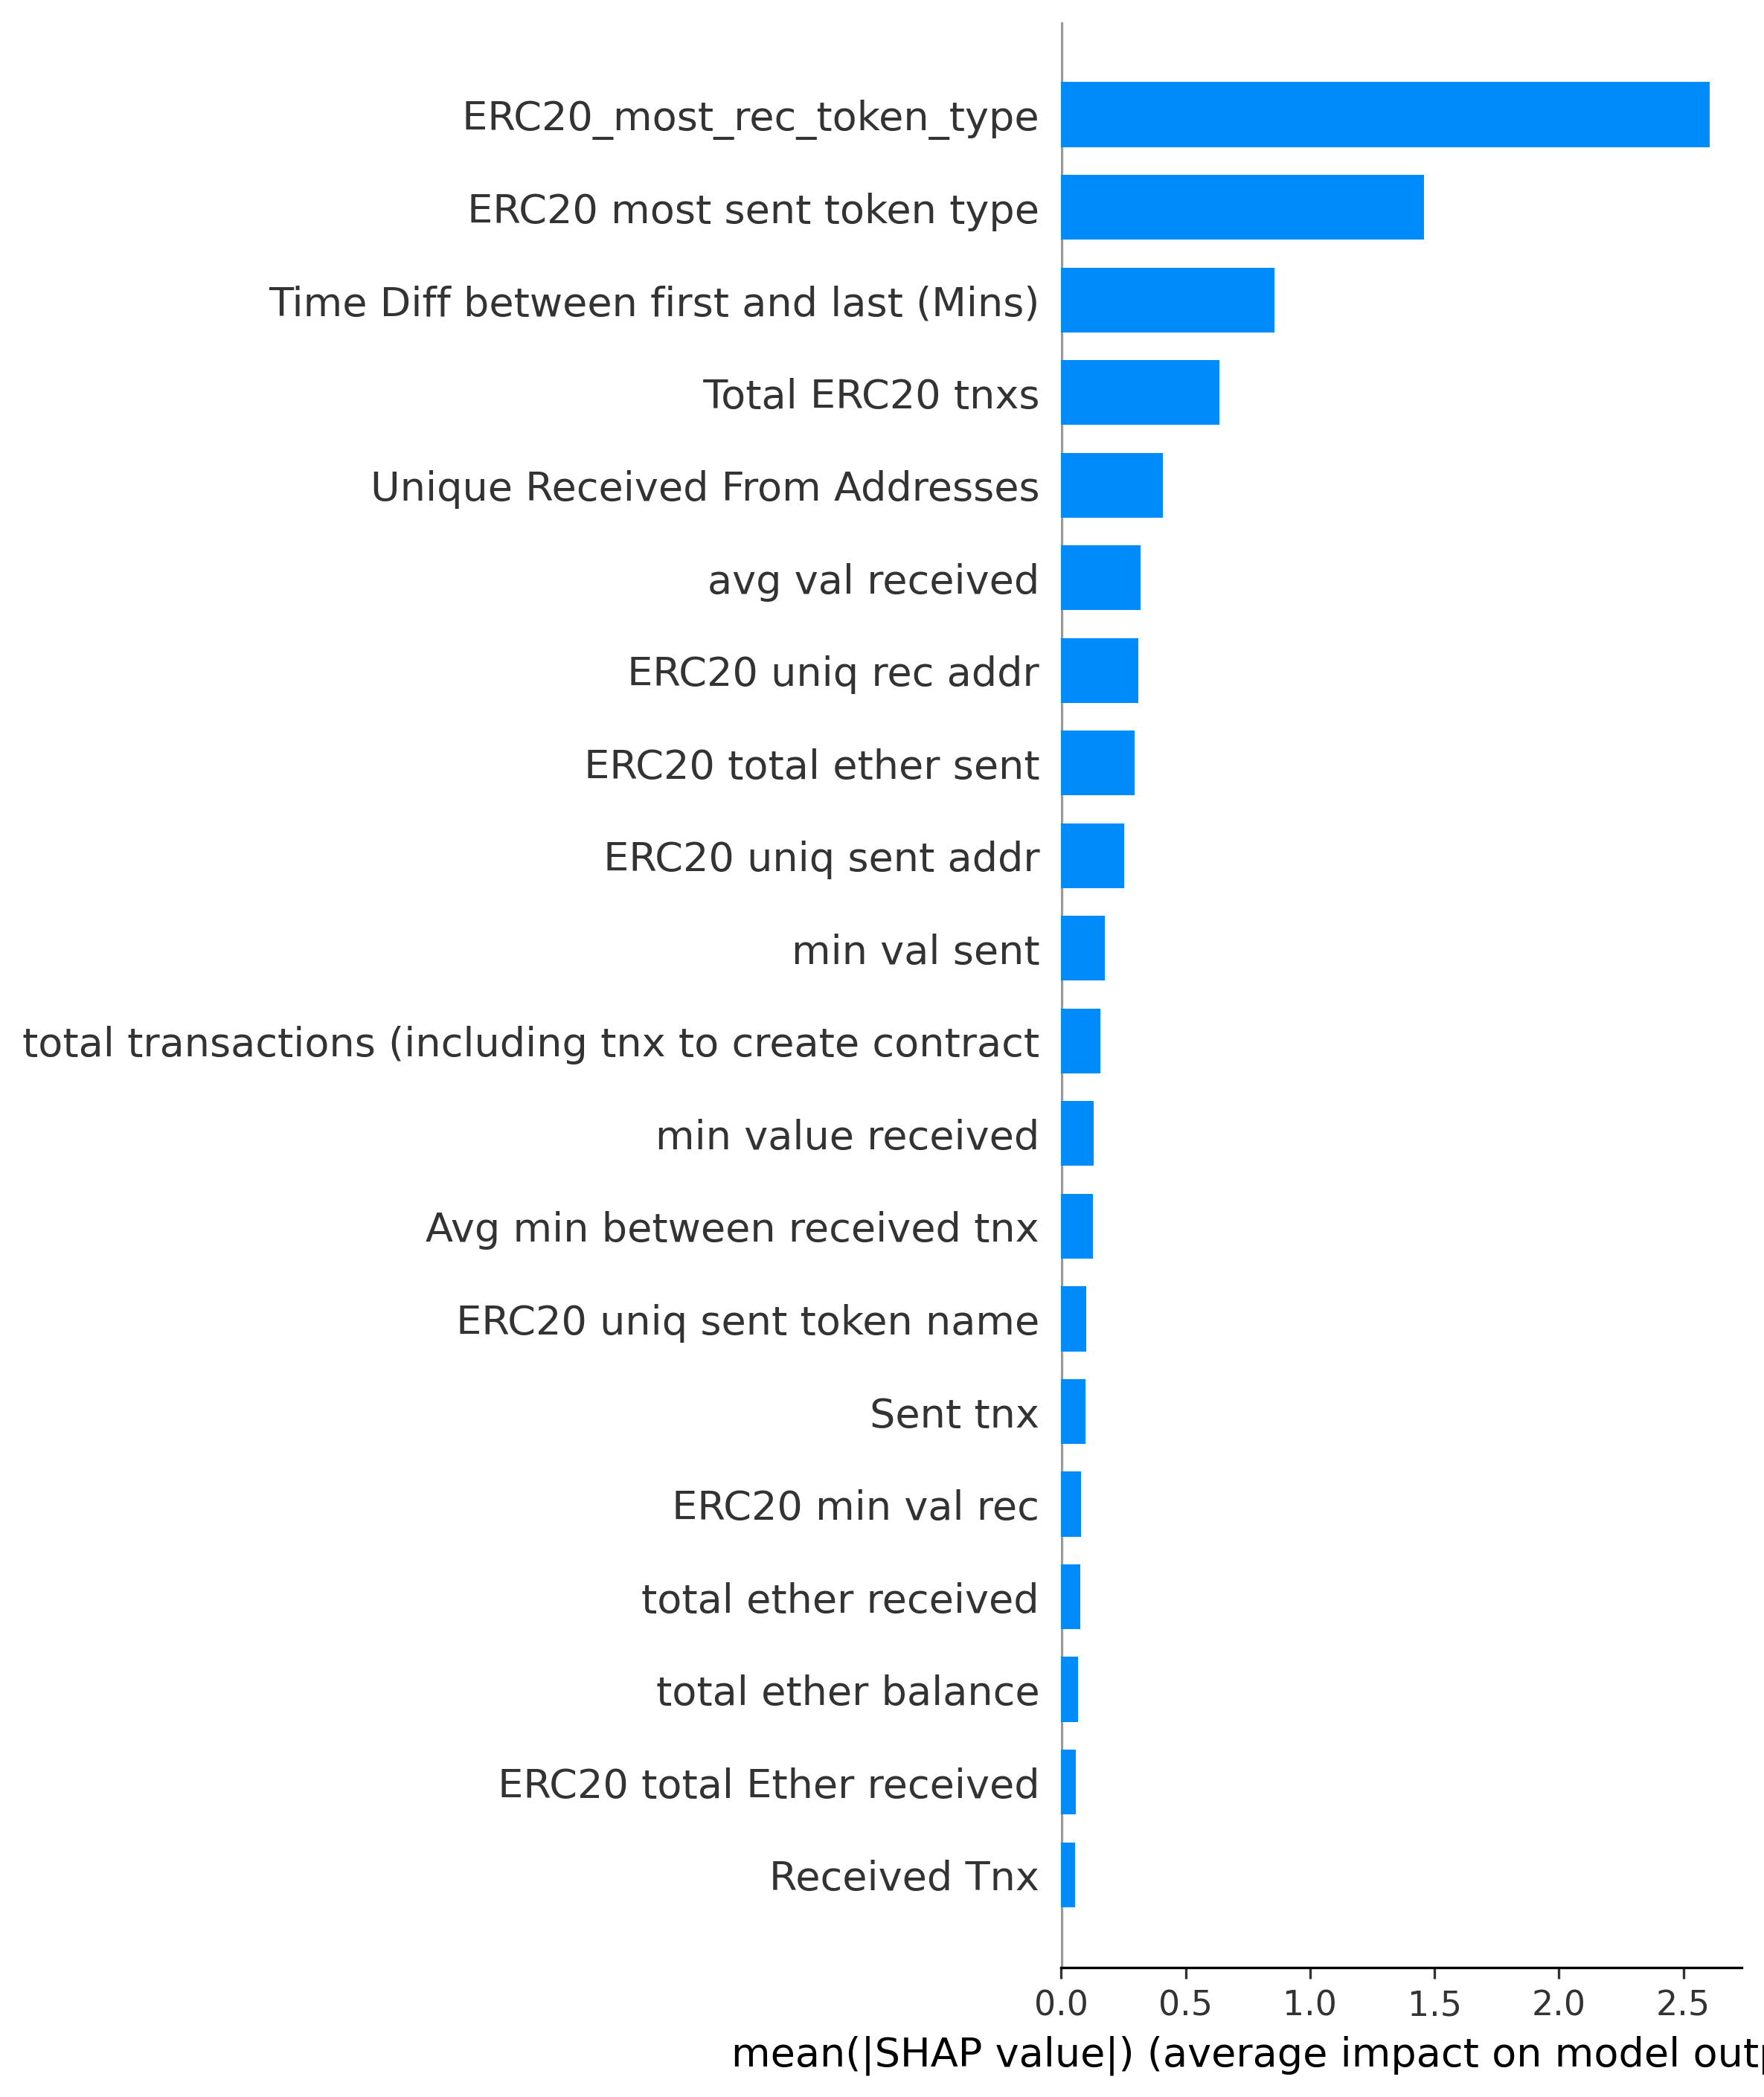


🎨 Beeswarm Plot


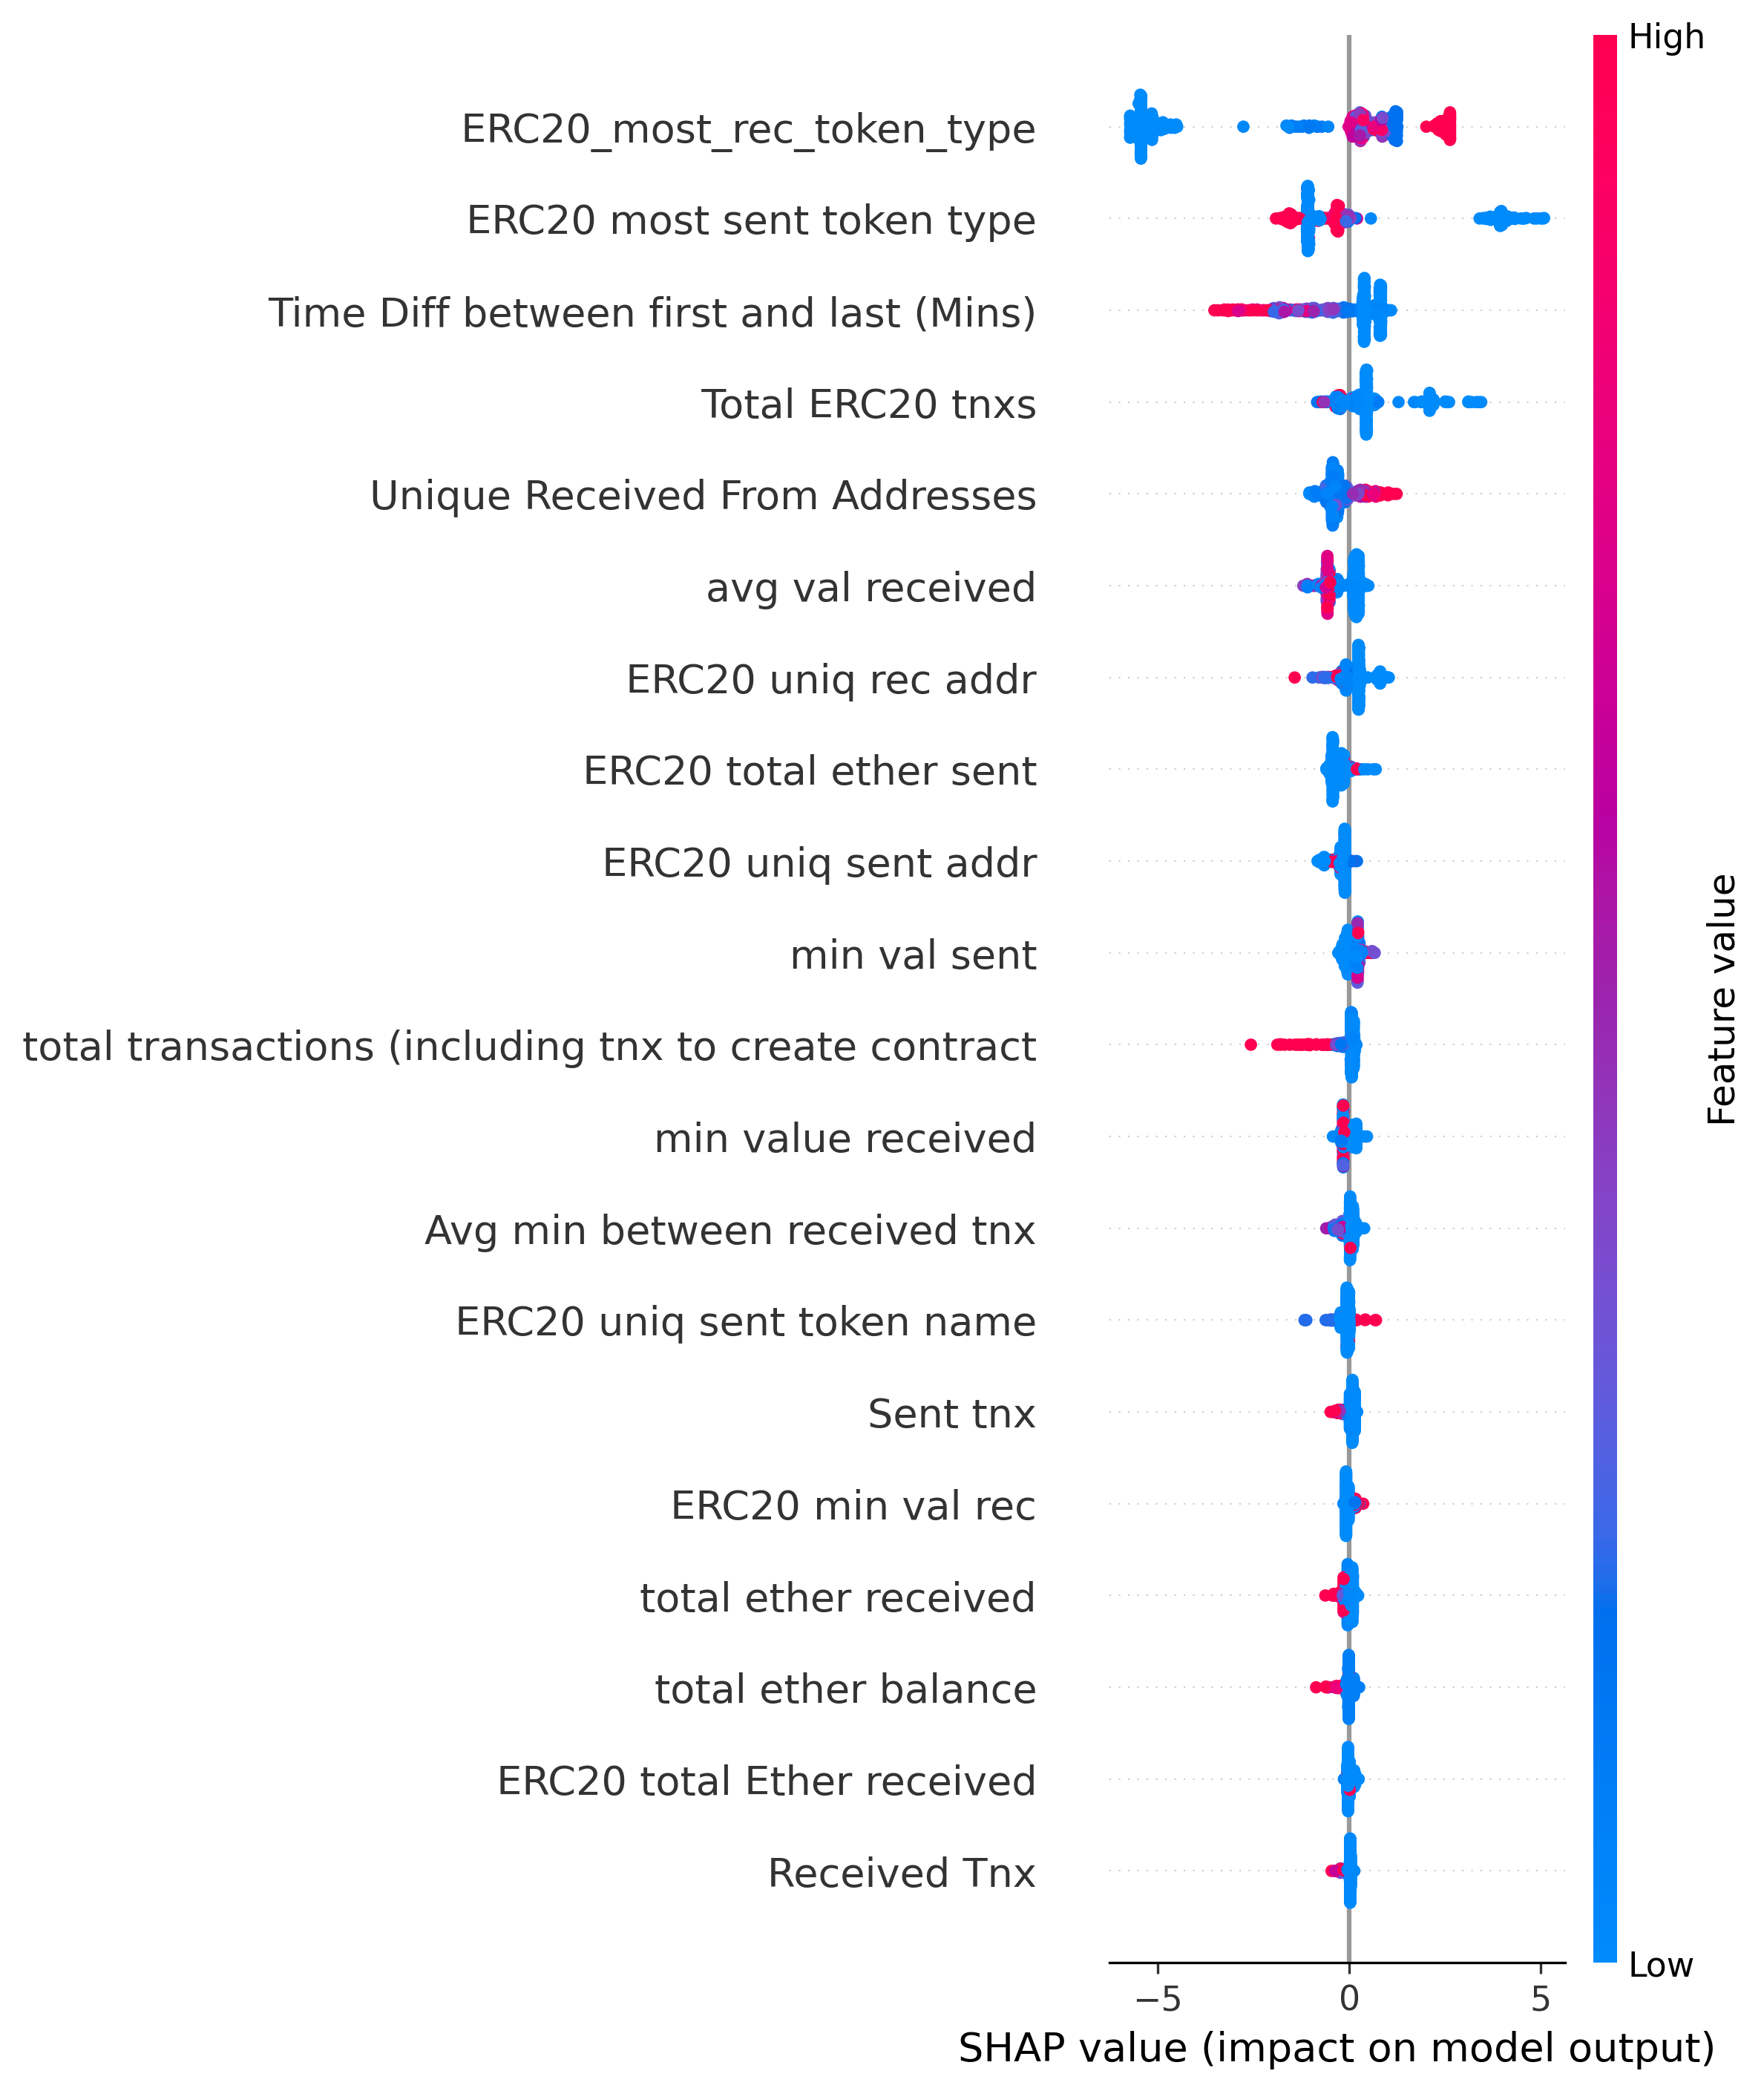


🎨 Waterfall Example


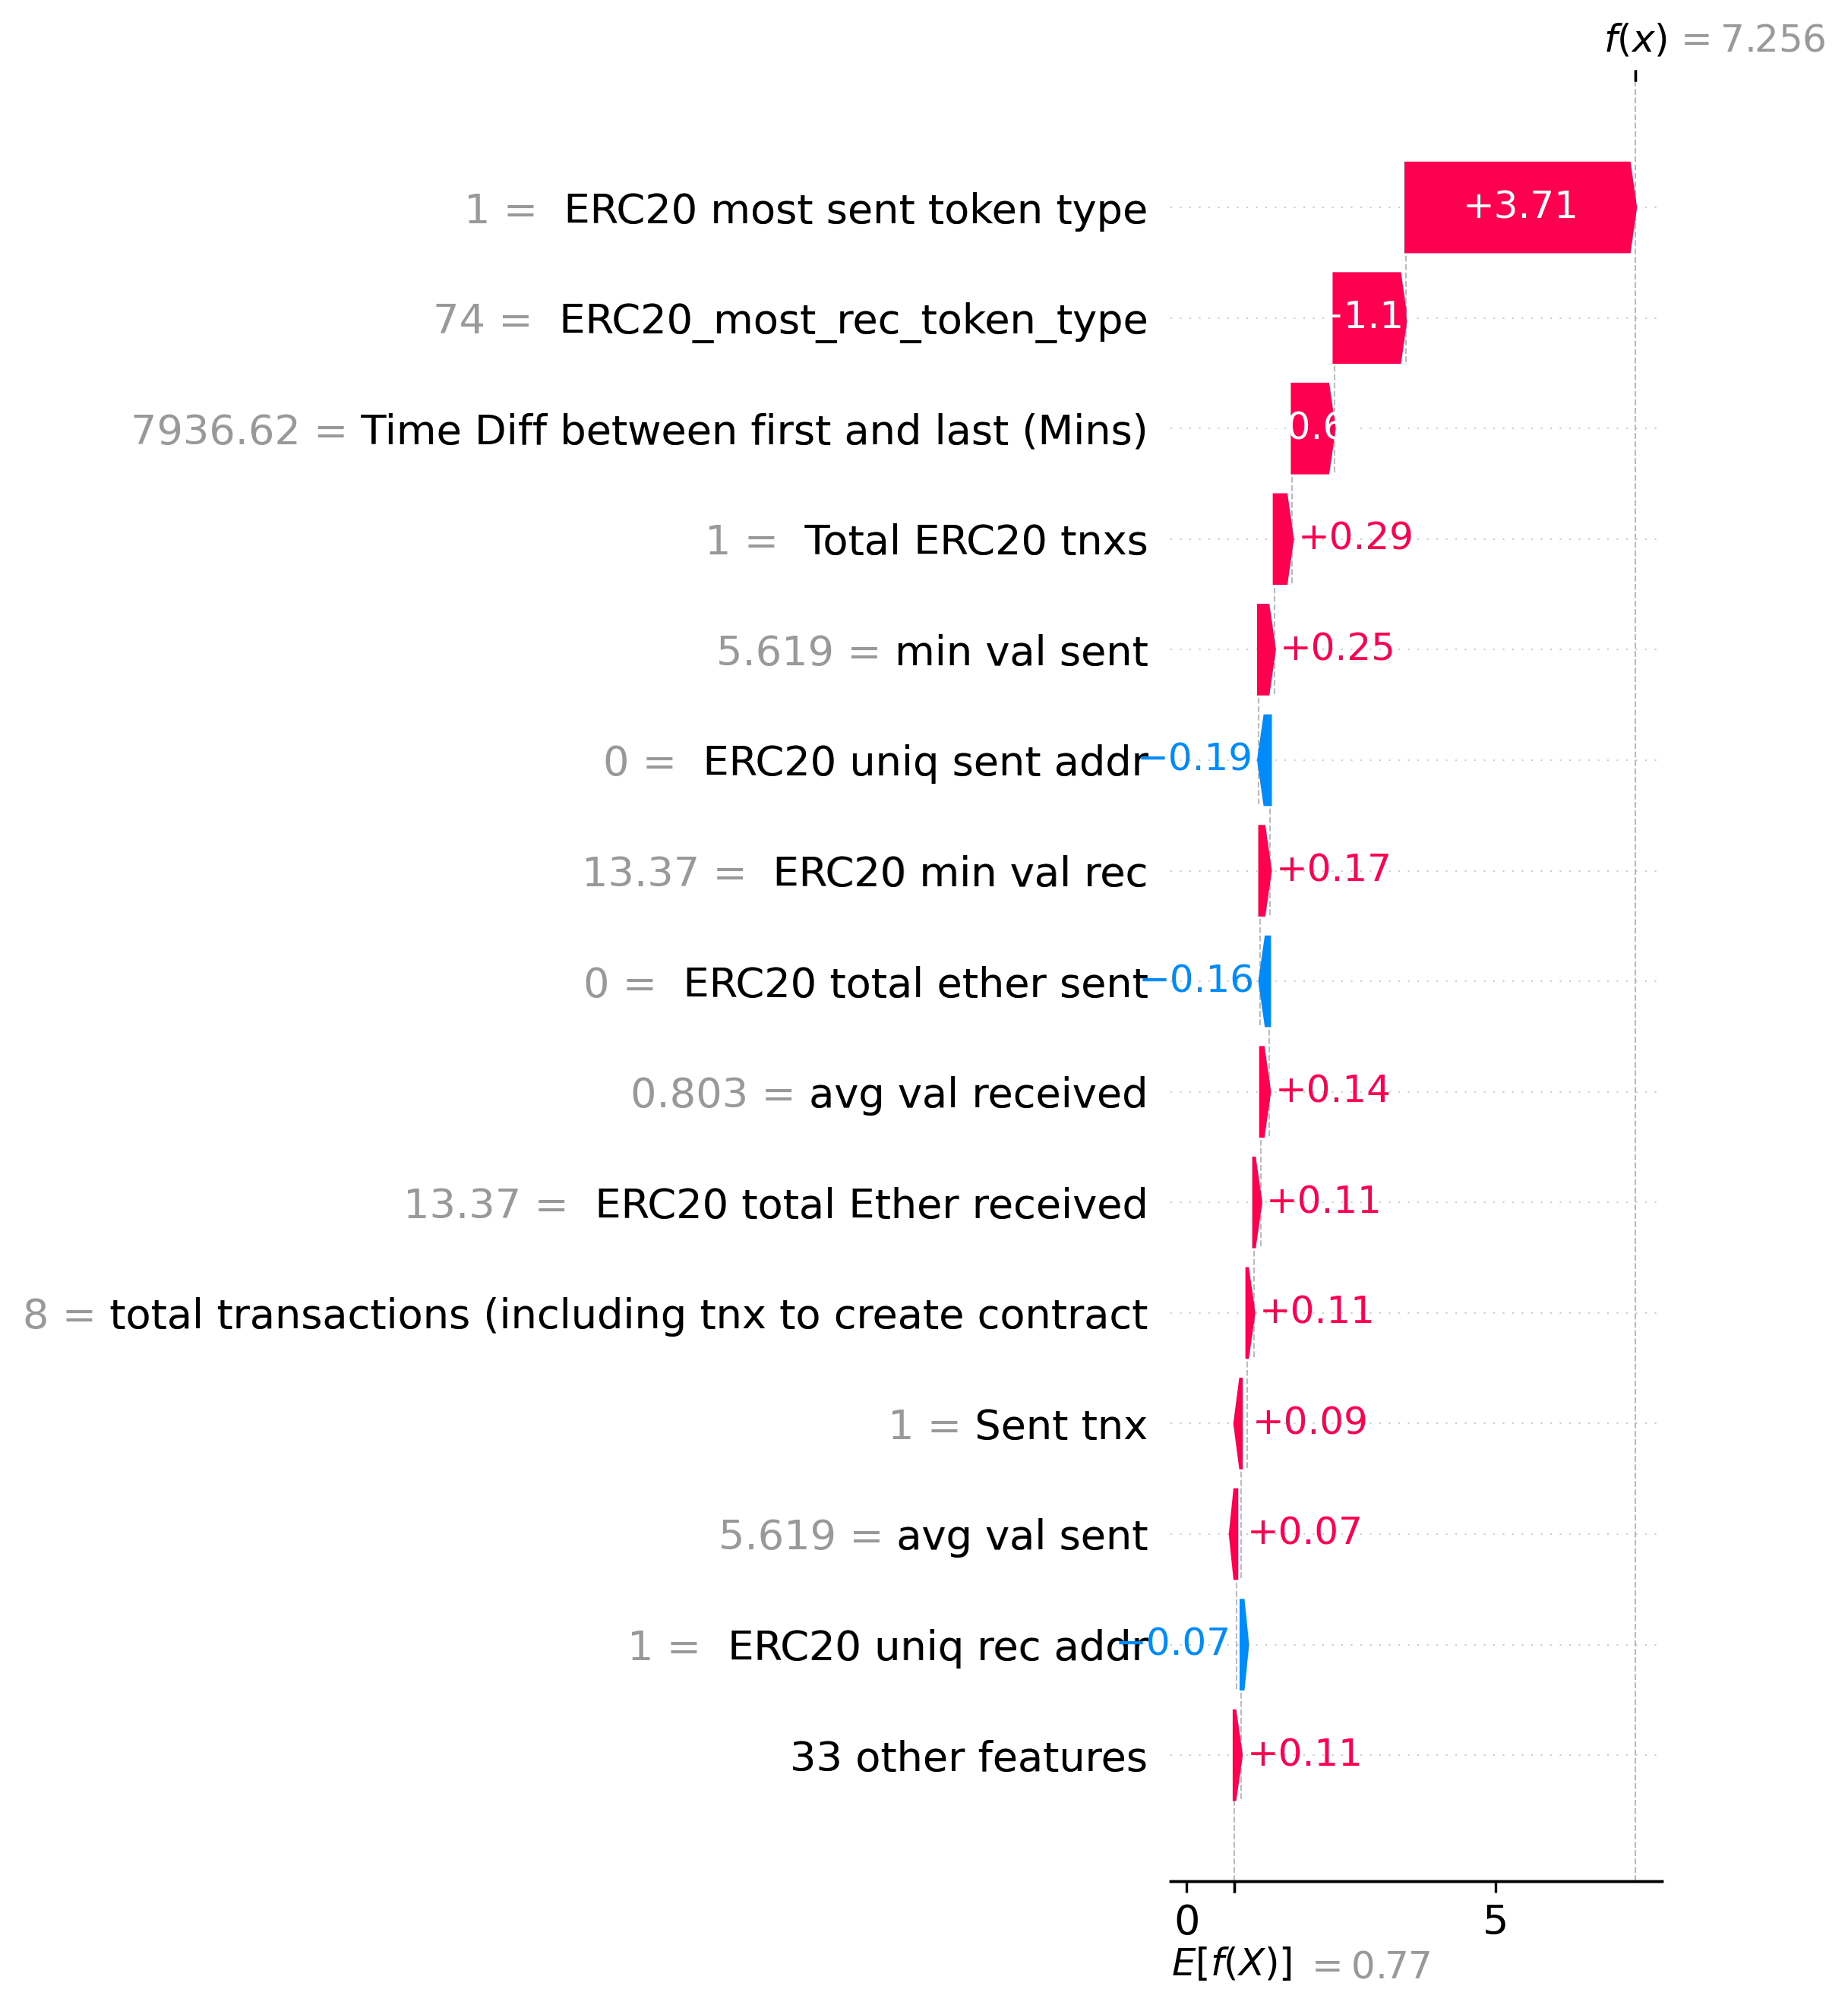


🎨 Force Plot


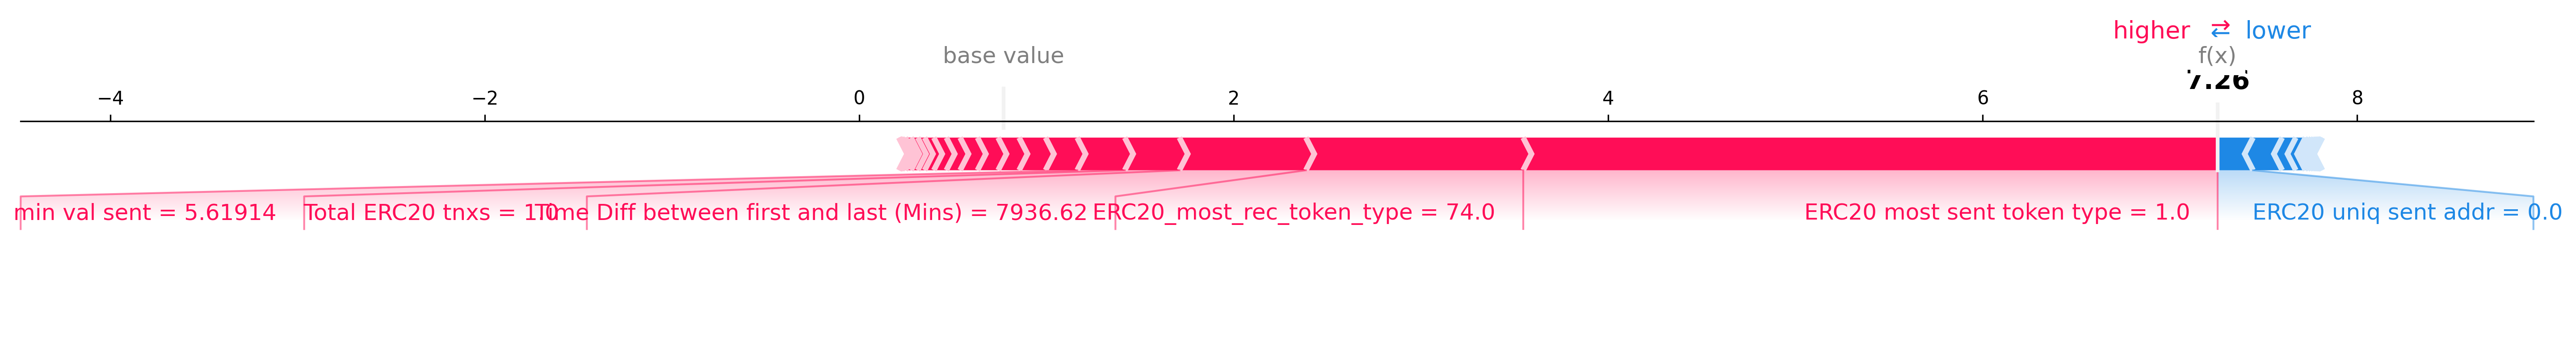

In [9]:
from IPython.display import Image, display

shap_plots = [
    ('Summary Bar', 'shap_summary_bar.png'),
    ('Beeswarm Plot', 'shap_summary_beeswarm.png'),
    ('Waterfall Example', 'shap_waterfall_fraud_example.png'),
    ('Force Plot', 'shap_force_fraud_example.png')
]

for title, filename in shap_plots:
    plot_path = shap_dir / filename
    if plot_path.exists():
        print(f"\n{'='*70}")
        print(f"🎨 {title}")
        print(f"{'='*70}")
        display(Image(filename=str(plot_path)))
    else:
        print(f"⚠️  {title} not found: {filename}")

## 🔮 Part 7: Prediction Examples

In [10]:
# Prepare features
X = df.drop(columns=['label'])
y = df['label']

# Make predictions on sample
sample_size = 100
sample_indices = np.random.choice(len(X), sample_size, replace=False)
X_sample = X.iloc[sample_indices]
y_sample = y.iloc[sample_indices]

predictions = model.predict(X_sample)
probabilities = model.predict_proba(X_sample)[:, 1]

# Create results dataframe
results_df = pd.DataFrame({
    'Actual': y_sample.values,
    'Predicted': predictions,
    'Probability': probabilities,
    'Correct': y_sample.values == predictions
})

# Statistics
accuracy = results_df['Correct'].mean()
fraud_cases = (y_sample == 1).sum()
fraud_detected = ((y_sample == 1) & (predictions == 1)).sum()

print("\n🔮 Prediction Sample Analysis (100 samples):")
print("="*70)
print(f"  Accuracy: {accuracy*100:.2f}%")
print(f"  Fraud cases in sample: {fraud_cases}")
print(f"  Fraud detected: {fraud_detected}")
print(f"  Detection rate: {fraud_detected/fraud_cases*100 if fraud_cases > 0 else 0:.2f}%")

# Display sample predictions
print("\n📋 Sample Predictions (first 10):")
print(results_df.head(10).to_string(index=False))


🔮 Prediction Sample Analysis (100 samples):
  Accuracy: 100.00%
  Fraud cases in sample: 28
  Fraud detected: 28
  Detection rate: 100.00%

📋 Sample Predictions (first 10):
 Actual  Predicted  Probability  Correct
      0          0     0.002478     True
      0          0     0.001610     True
      1          1     0.999308     True
      0          0     0.002663     True
      1          1     0.997245     True
      1          1     0.999151     True
      1          1     0.997192     True
      0          0     0.007726     True
      0          0     0.001812     True
      0          0     0.008579     True


In [11]:
# Prediction probability distribution
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Probability Distribution by Actual Label', 'Prediction Confidence')
)

# Box plot by actual label
for label in [0, 1]:
    mask = results_df['Actual'] == label
    fig.add_trace(
        go.Box(
            y=results_df[mask]['Probability'],
            name=f"{'Normal' if label == 0 else 'Fraud'}",
            marker_color='#2ecc71' if label == 0 else '#e74c3c'
        ),
        row=1, col=1
    )

# Histogram of probabilities
fig.add_trace(
    go.Histogram(
        x=results_df['Probability'],
        nbinsx=20,
        marker_color='#3498db',
        name='Probability Distribution'
    ),
    row=1, col=2
)

fig.update_layout(
    title_text="Prediction Analysis",
    title_font_size=20,
    height=500,
    showlegend=True
)

fig.update_xaxes(title_text="Actual Label", row=1, col=1)
fig.update_yaxes(title_text="Fraud Probability", row=1, col=1)
fig.update_xaxes(title_text="Fraud Probability", row=1, col=2)
fig.update_yaxes(title_text="Count", row=1, col=2)

fig.show()

## 📊 Part 8: Feature Correlation Analysis

In [12]:
# Get top 15 features for correlation analysis
top_15_features = importance_df.head(15)['feature'].tolist()
X_top = X[top_15_features]

# Calculate correlation
correlation = X_top.corr()

# Create heatmap
fig = go.Figure(data=go.Heatmap(
    z=correlation.values,
    x=correlation.columns,
    y=correlation.columns,
    colorscale='RdBu',
    zmid=0,
    text=np.round(correlation.values, 2),
    texttemplate='%{text}',
    textfont={"size": 8},
    hovertemplate='%{x}<br>%{y}<br>Correlation: %{z:.3f}<extra></extra>'
))

fig.update_layout(
    title="Feature Correlation Matrix (Top 15 Features)",
    title_font_size=20,
    height=800,
    width=900,
    xaxis={'side': 'bottom'},
    yaxis={'side': 'left'}
)

fig.update_xaxes(tickangle=45)

fig.show()

## 📈 Part 9: Summary Report

In [13]:
print("\n" + "="*80)
print(" "*20 + "📊 FINAL SUMMARY REPORT")
print("="*80)

print("\n📁 Dataset Information:")
print(f"  - Total Samples: {results['samples']['total']:,}")
print(f"  - Training Samples: {results['samples']['train']:,}")
print(f"  - Test Samples: {results['samples']['test']:,}")
print(f"  - Features: {results['feature_count']}")
print(f"  - Fraud Rate: {df['label'].mean()*100:.2f}%")

print("\n🎯 Model Performance:")
print(f"  - PR-AUC Score:    {results['metrics']['pr_auc']:.4f} {'🏆' if results['metrics']['pr_auc'] > 0.99 else ''}")
print(f"  - ROC-AUC Score:   {results['metrics']['roc_auc']:.4f} {'🏆' if results['metrics']['roc_auc'] > 0.99 else ''}")
print(f"  - Precision:       {results['metrics']['precision']:.4f}")
print(f"  - Recall:          {results['metrics']['recall']:.4f}")
print(f"  - F1-Score:        {results['metrics']['f1']:.4f}")

print("\n📉 Error Analysis:")
print(f"  - False Positives: {fp} (Normal classified as Fraud)")
print(f"  - False Negatives: {fn} (Fraud classified as Normal)")
print(f"  - False Positive Rate: {fpr:.4f}")
print(f"  - False Negative Rate: {fnr:.4f}")

print("\n🔬 Top 5 Most Important Features:")
for idx, row in importance_df.head(5).iterrows():
    print(f"  {idx+1}. {row['feature'][:50]:50s} ({row['importance']:.4f})")

print("\n⚙️  Hyperparameters:")
for key, value in results['hyperparameters'].items():
    print(f"  - {key}: {value}")

print("\n✅ Model Status: PRODUCTION READY")
print("\n" + "="*80)
print("📝 Next Steps:")
print("  1. Deploy model for real-time fraud detection")
print("  2. Monitor performance on new data")
print("  3. Regular model retraining with updated data")
print("  4. A/B testing with baseline models")
print("="*80)


                    📊 FINAL SUMMARY REPORT

📁 Dataset Information:
  - Total Samples: 6,537
  - Training Samples: 5,229
  - Test Samples: 1,308
  - Features: 47
  - Fraud Rate: 33.33%

🎯 Model Performance:
  - PR-AUC Score:    0.9998 🏆
  - ROC-AUC Score:   0.9999 🏆
  - Precision:       0.9977
  - Recall:          0.9954
  - F1-Score:        0.9966

📉 Error Analysis:
  - False Positives: 1 (Normal classified as Fraud)
  - False Negatives: 2 (Fraud classified as Normal)
  - False Positive Rate: 0.0011
  - False Negative Rate: 0.0046

🔬 Top 5 Most Important Features:
  1.  ERC20_most_rec_token_type                         (0.3340)
  2. Time Diff between first and last (Mins)            (0.1385)
  3.  ERC20 most sent token type                        (0.0498)
  4.  Total ERC20 tnxs                                  (0.0478)
  5.  ERC20 uniq rec addr                               (0.0344)

⚙️  Hyperparameters:
  - n_estimators: 300
  - learning_rate: 0.05
  - max_depth: 6
  - scale_pos_weig

## 💾 Export Results Summary

In [14]:
# Create comprehensive summary
summary = {
    'timestamp': results['timestamp'],
    'dataset': {
        'total_samples': results['samples']['total'],
        'train_samples': results['samples']['train'],
        'test_samples': results['samples']['test'],
        'features': results['feature_count'],
        'fraud_rate': float(df['label'].mean())
    },
    'performance': results['metrics'],
    'error_analysis': {
        'false_positives': int(fp),
        'false_negatives': int(fn),
        'false_positive_rate': float(fpr),
        'false_negative_rate': float(fnr)
    },
    'top_features': importance_df.head(10).to_dict('records')
}

# Save summary
summary_path = model_dir / 'visualization_summary.json'
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)

print(f"✅ Summary exported to: {summary_path}")
print(f"\n📊 Visualization complete! All results analyzed.")

✅ Summary exported to: ..\models\visualization_summary.json

📊 Visualization complete! All results analyzed.
